In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-dmage/car_damage_3.jpeg
/kaggle/input/car-dmage/car_damage_2.jpeg
/kaggle/input/car-dmage/car_damage_6.jpeg
/kaggle/input/car-dmage/car_damage_1.jpeg
/kaggle/input/car-dmage/car_damage_4.jpeg
/kaggle/input/car-dmage/car_damage_5.jpg


In [2]:
# Basic libraries
import os
import json
import base64
import re

import numpy as np
import pandas as pd
from PIL import Image

# See what data is available under /kaggle/input
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-dmage/car_damage_3.jpeg
/kaggle/input/car-dmage/car_damage_2.jpeg
/kaggle/input/car-dmage/car_damage_6.jpeg
/kaggle/input/car-dmage/car_damage_1.jpeg
/kaggle/input/car-dmage/car_damage_4.jpeg
/kaggle/input/car-dmage/car_damage_5.jpg


In [3]:
from kaggle_secrets import UserSecretsClient

from google.genai import types
from google import genai  # for Vision

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService

print("✅ Imports complete.")

✅ Imports complete.


In [4]:
# 1️⃣ Auth – get API key from Kaggle secret GOOGLE_API_KEY
try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f" Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

# 2️⃣ Retry config for ADK LLM calls
retry_config = types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],
)

# 3️⃣ Gemini Vision client
vision_client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])
print("✅ Gemini Vision client ready.")

✅ Gemini API key setup complete.
✅ Gemini Vision client ready.


In [5]:
# 3. Custom tools

def analyze_damage_description(description: str) -> dict:
    """Analyzes a user text description of car damage.

    Args:
        description: Free-form user text describing where and how the car is damaged.

    Returns:
        dict with status and structured damage info.
    """
    if not description or not description.strip():
        return {"status": "error", "error_message": "Empty description."}

    # Simple structure – you can extend later
    return {
        "status": "success",
        "damage_type": "unknown",
        "location": "unspecified",
        "notes": description.strip(),
    }


def analyze_damage_image(image_bytes: bytes, mime_type: str = "image/jpeg") -> dict:
    """Analyzes an image of a damaged car using Gemini Vision.

    Args:
        image_bytes: Raw bytes of the uploaded image.
        mime_type: Image mime type, e.g. "image/jpeg" or "image/png".

    Returns:
        dict with status and structured findings, e.g.:
        {
          "status": "success",
          "visible_damage": "...",
          "approx_severity": "low/medium/high",
          "location_hint": "...",
          "notes": "..."
        }
    """
    if not image_bytes:
        return {"status": "error", "error_message": "No image data provided."}

    try:
        vision_prompt = """
You are an expert car damage inspector.

Look at this car image and describe only the visible external damage.

IMPORTANT:
- Respond ONLY with a single JSON object.
- Do NOT add any explanations or text before or after the JSON.
- Do NOT wrap the JSON in Markdown code fences.

Use this exact JSON format:
{
  "visible_damage": "short description of the main visible damage",
  "approx_severity": "one of: low, medium, high",
  "location_hint": "where on the car (e.g. front bumper, rear right door, left side panel, headlight, etc.)",
  "notes": "optional short notes, e.g. paint only, possible structural damage, lights/sensors affected, etc."
}
"""

        inline_image = {
            "inline_data": {
                "data": base64.b64encode(image_bytes).decode("utf-8"),
                "mime_type": mime_type,
            }
        }

        response = vision_client.models.generate_content(
            model="gemini-2.5-flash",
            contents=[
                {
                    "role": "user",
                    "parts": [
                        {"text": vision_prompt},
                        inline_image,
                    ],
                }
            ],
        )

        raw_text = (response.text or "").strip()

        # Debug: see what Vision returned
        print("🔍 Raw Vision model output:\n", raw_text)

        # 1) Direct JSON parse
        try:
            parsed = json.loads(raw_text)
        except Exception:
            cleaned = raw_text

            # 2) Remove ```json ... ``` fences if present
            if cleaned.startswith("```"):
                cleaned = cleaned.strip("`")
                lines = cleaned.splitlines()
                if lines and lines[0].strip().lower().startswith("json"):
                    cleaned = "\n".join(lines[1:])

            # 3) Try parse again
            try:
                parsed = json.loads(cleaned)
            except Exception:
                # 4) Final attempt: extract first {...} with regex
                match = re.search(r"\{.*\}", raw_text, re.DOTALL)
                if not match:
                    return {
                        "status": "error",
                        "error_message": "Could not find JSON object in Vision output.",
                        "raw_response": raw_text,
                    }
                json_str = match.group(0)
                parsed = json.loads(json_str)

        if not isinstance(parsed, dict) or "visible_damage" not in parsed:
            return {
                "status": "error",
                "error_message": "Unexpected response format from Vision model.",
                "raw_response": parsed,
            }

        parsed["status"] = "success"
        return parsed

    except Exception as e:
        return {
            "status": "error",
            "error_message": f"Vision analysis failed: {str(e)}",
        }


def estimate_severity(damage_info: dict) -> dict:
    """Uses Vision approx_severity if available; otherwise defaults to 'medium'."""
    image_info = damage_info.get("image_analysis", {})
    text_info = damage_info.get("text_analysis", {})

    approx = image_info.get("approx_severity", "medium")

    reasoning_parts = []
    if image_info.get("visible_damage"):
        reasoning_parts.append(f"Vision: {image_info['visible_damage']}")
    if image_info.get("notes"):
        reasoning_parts.append(f"Notes: {image_info['notes']}")
    if text_info.get("notes"):
        reasoning_parts.append(f"User description: {text_info['notes']}")

    return {
        "status": "success",
        "severity_level": approx,
        "reasoning": " | ".join(reasoning_parts),
    }


def suggest_repair_plan(damage_info: dict) -> dict:
    """Suggests a repair plan based on damage information.

    Returns:
        dict with recommended_repair, difficulty, and safety_notes.
    """
    # Simple default suggestion – agent will add more detail in language
    return {
        "status": "success",
        "recommended_repair": "Visit a local body shop for inspection and repair.",
        "difficulty": "professional",
        "safety_notes": "If lights or sensors are affected, avoid long or high-speed trips until checked.",
    }

print("✅ Custom tools defined.")

✅ Custom tools defined.


In [6]:
# 4. Main agent

car_damage_agent = LlmAgent(
    name="car_damage_agent",
    model=Gemini(model="gemini-2.5-flash", retry_options=retry_config),
    instruction="""
    You are a helpful Car Damage Explainer Agent.

    - You receive structured information about car damage (from image + text tools).
    - Your goals:
      1. Explain what type of damage the car likely has and where.
      2. Provide or confirm a simple severity level: low / medium / high.
      3. Suggest practical next steps for repair in non-technical language.
      4. Add important safety notes when relevant.
      5. Format responses clearly for normal car owners (not experts).

    You must ONLY use the information given in the JSON passed in the prompt.
    Do not pretend to see the real car beyond what the tools describe.
    Never claim to be a certified mechanic or insurance assessor.
    """,
    tools=[],  # We call Python tools manually in the notebook
)

runner = InMemoryRunner(agent=car_damage_agent)
print("✅ Car Damage Explainer Agent initialized.")

✅ Car Damage Explainer Agent initialized.


In [7]:

async def run_car_damage_agent_with_image_and_text(
    image_path: str,
    user_description: str = "",
    owner_name: str = "Shubham Ahire",
    car_number: str = "ABC-1234",
    insurance_company: str = "SKA Insurance"
):
    # 1️⃣ Read image bytes
    with open(image_path, "rb") as f:
        image_bytes = f.read()

    # 2️⃣ Use tools to build structured info
    image_info = analyze_damage_image(image_bytes)
    if user_description:
        text_info = analyze_damage_description(user_description)
    else:
        text_info = {
            "status": "success",
            "damage_type": "unknown",
            "location": "unspecified",
            "notes": "No user description provided.",
        }

    damage_info = {
        "image_analysis": image_info,
        "text_analysis": text_info,
    }

    # 3️⃣ Add severity info
    severity_info = estimate_severity(damage_info)
    damage_info["severity_estimate"] = severity_info

    print("📝 Structured damage info going into the agent:")
    print(json.dumps(damage_info, indent=2))

    # 4️⃣ Build prompt with professional report layout
    prompt = f"""
You are a Car Damage Explainer Agent working for an insurance-style report system.

The insurance brand name is: "{insurance_company}".

Car owner name: {owner_name}
Car number: {car_number}

Here is the structured information about the car damage:

{json.dumps(damage_info, indent=2)}

Using ONLY this information, generate a professional-looking **Markdown report**.

### Layout requirements

1. Start with a header "card" style section like:

**{insurance_company} – Car Damage Assessment Report**

- **Owner:** {owner_name}
- **Car No.:** {car_number}
- **Assessment Type:** Visual external damage estimation
- **Model used:** AI assistant (not a certified mechanical inspection)

2. Then add a **Summary** section:
   - 2–4 lines of plain-language explanation for a normal car owner.

3. Add a **Damage Assessment** section with a table:

| Aspect          | Details |
|----------------|---------|
| Visible damage | (use image_analysis.visible_damage) |
| Location       | (use image_analysis.location_hint if available) |
| Severity       | (use severity_estimate.severity_level: low / medium / high) |
| Notes          | (combine image_analysis.notes and any important context) |

4. Add a **Recommended Action & Rough Cost** section with a second table:

| Item                  | Recommendation / Info |
|-----------------------|-----------------------|
| Suggested repair type | e.g. DIY touch-up / local workshop / professional body shop |
| Urgency               | e.g. low / medium / high urgency, with 1 short reason |
| Rough cost category   | Low / Medium / High (with 1 short line of explanation, NO exact price or currency) |
| Safety notes          | Any warnings (e.g. if lights, sensors, or structure might be affected) |

5. Finish with a **Disclaimer** section:
   - 1–3 sentences clearly stating that:
     - This is NOT a professional or legal assessment.
     - A certified mechanic or body shop must inspect the vehicle in person.
     - Cost and severity are approximate and only for initial guidance.

Write everything in clean Markdown. Do not include any raw JSON in the final report.
"""

    # 5️⃣ Call the agent
    # response = await runner.run(input=prompt)
    response = await runner.run_debug(prompt)
    return response



def pretty_print_agent_response(response):
    """Extract and print plain text from the agent response."""
    messages = response if isinstance(response, list) else [response]

    printed_any = False

    for msg in messages:
        content = getattr(msg, "content", None)
        if content is None:
            continue

        # Case 1: response.content.text
        if hasattr(content, "text") and content.text:
            if not printed_any:
                print("\n💬 Agent response:\n")
            print(content.text)
            printed_any = True
            continue

        # Case 2: response.content.parts with text
        if hasattr(content, "parts"):
            for part in content.parts:
                if getattr(part, "text", None):
                    if not printed_any:
                        print("\n💬 Agent response:\n")
                    print(part.text)
                    printed_any = True

    if not printed_any:
        print("⚠️ Could not extract text cleanly. Raw response:")
        print(response)

print("✅ Helper functions ready.")

✅ Helper functions ready.


📸 Car Image:


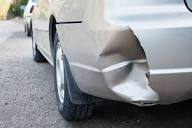

🔍 Raw Vision model output:
 {
  "visible_damage": "Severe crushing, deformation, and tearing of the rear bumper",
  "approx_severity": "high",
  "location_hint": "Rear right bumper and adjacent lower quarter panel",
  "notes": "Extensive creasing, paint loss, and material damage to bumper plastic. Denting also visible on the metal quarter panel above the bumper line. Potential for underlying structural or mounting damage."
}
📝 Structured damage info going into the agent:
{
  "image_analysis": {
    "visible_damage": "Severe crushing, deformation, and tearing of the rear bumper",
    "approx_severity": "high",
    "location_hint": "Rear right bumper and adjacent lower quarter panel",
    "notes": "Extensive creasing, paint loss, and material damage to bumper plastic. Denting also visible on the metal quarter panel above the bumper line. Potential for underlying structural or mounting damage.",
    "status": "success"
  },
  "text_analysis": {
    "status": "success",
    "damage_type": 

In [8]:
# # Pick one test image from your dataset
# image_path = "/kaggle/input/car-dmage/car_damage_2.jpeg"
# user_description = "This is a photo of the rear side of the car after a low-speed parking accident."

# # Optional: display the image
# if os.path.exists(image_path):
#     display(Image.open(image_path))
# else:
#     print("❌ Image path not found:", image_path)

# # Run the agent
# response = await run_car_damage_agent_with_image_and_text(
#     image_path=image_path,
#     user_description=user_description,
# )

# pretty_print_agent_response(response)




image_path = "/kaggle/input/car-dmage/car_damage_2.jpeg"

# 1️⃣ Display image at the top
print("📸 Car Image:")
if os.path.exists(image_path):
    display(Image.open(image_path))
else:
    print("❌ Image path not found:", image_path)



response = await run_car_damage_agent_with_image_and_text(
    image_path=image_path,
    user_description="This is a photo of the rear side of the car after a low-speed parking accident.",
    owner_name="Shubham Ahire",
    car_number="SKA-2025-09",
    insurance_company="SKA Insurance"
)

pretty_print_agent_response(response)